In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

## Load SPS BPM data
Data from first turn for 25 ns beam (closed orbit subtracted)

In [11]:
# Load data for injection trajectory
bpm_data = xt.json.load('bpm_data.json')

# Use Xsuite table for easy access and visualization
bpm_meas = xt.Table(data={
    'name': np.array(bpm_data['bpm_name']),
    'x_meas': np.array(bpm_data['x_position']),
})
bpm_meas

Table: 100 rows, 2 cols
name             x_meas
bph.12008    -0.0008528
bph.12208     0.0014424
bph.12408     0.0041292
bph.12608     0.0052441
bph.12808     0.0034377
bph.13008        0.0006
bph.13208      0.000576
bph.13408     0.0031604
bph.13608     0.0053838
bph.20208     0.0041483
...
bpce.61931      -4.1e-06
bph.62008       -5.9e-06
bph.62208       0.001132
bph.62408      0.0023606
bph.62608      0.0028319
bph.62808      0.0017244
bph.63008      0.0005812
bph.63208      0.0007229
bph.63408      0.0017668
bph.63608       0.002735

In [4]:
# Look at data for one BPM
bpm_meas['x_meas', 'bph.62608']

0.0028319

Text(0.5, 0, 'Monitor number')

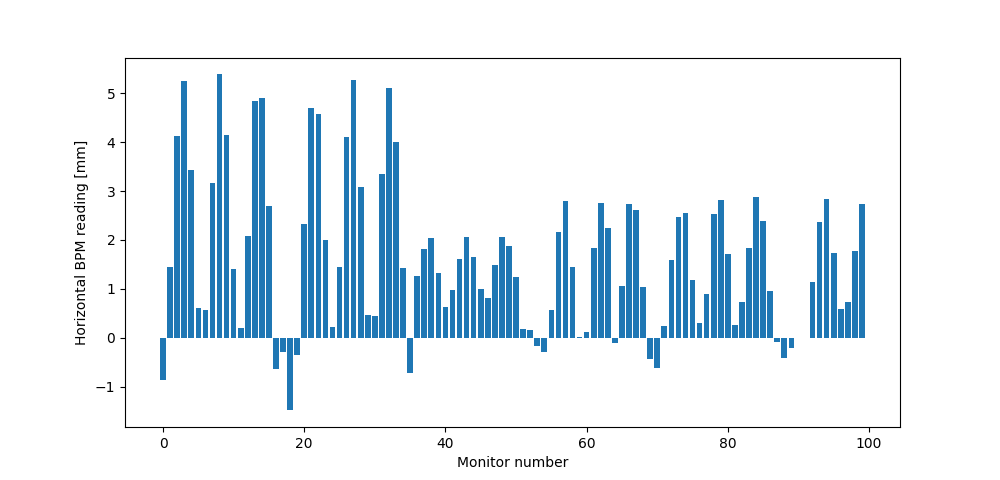

In [5]:
# Plot data (excursions observed to be larger in the first two sectors)
plt.figure(figsize=(10, 4.8))
plt.bar(height=bpm_meas.x_meas*1e3, x=range(len(bpm_meas)))
plt.ylabel('Horizontal BPM reading [mm]')
plt.xlabel('Monitor number')

### Load Xsuite model of the SPS

In [6]:
# Load lattice
env = xt.load_madx_lattice('acc-models-sps/sps.seq')
sps = env['sps']

# Load optics
sps.vars.load_madx('acc-models-sps/strengths/lhc_q20.str')

# Set reference patricle
sps.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV, q0=1, p0c=26e9)

In [7]:
# Setup RF (200 MHz and 800 MHz)
sps.set('actcse.31632', voltage=4.5e6, lag=180., frequency=200e6)
sps.set('acl.31735', voltage=0.45e6, lag=0., frequency=800e6)

In [8]:
# Twiss to check the model
tw = sps.twiss()
print(f'qx={tw.qx:.4f}, qy={tw.qy:.4f}, qs={tw.qs:.4f}')

qx=20.1300, qy=20.1800, qs=0.0117


### Compute first turn trajectory

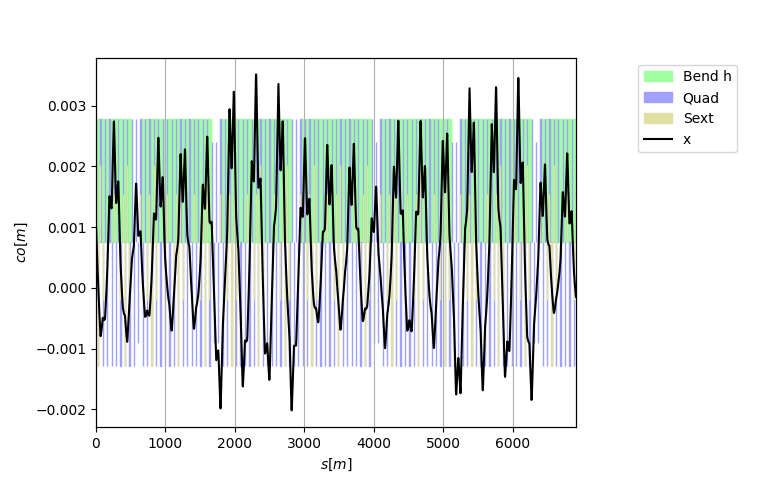

In [9]:
# Use variables to define the initial conditions
sps['x_inj'] = 1e-3
sps['px_inj'] = 0.
sps['delta_inj'] = 2e-4
sps['zeta_inj'] = 0.

tw_turn_1 = sps.twiss(
    betx=1, bety=1,
    x=sps['x_inj'], px=sps['px_inj'],
    delta=sps['delta_inj'], zeta=sps['zeta_inj'])

tw_turn_1.plot('x')

### Can we find initial conditions for which the model reproduces the measured trajectory?

We can use the Xsuite optimizer to seach for such conditions

In [10]:
# Define an action computing the first tune trajectory
@xt.Action
def tw_1st_turn():
    return sps.twiss(
        betx=1, bety=1,
        x=sps['x_inj'], px=sps['px_inj'],
        delta=sps['delta_inj'], zeta=sps['zeta_inj'])

In [11]:
# The action can be used to define an optimization target, for example:
target_bph_63608 = tw_1st_turn.target('x', 1e-3, at='bph.63608')

In [14]:
# We can use a python for loop to create targets aiming at maching the measurements at all BPMs
targets = []
for nn in bpm_meas['name']:
    targets.append(tw_1st_turn.target('x', bpm_meas['x_meas', nn], at=nn))
targets

[Target(('x', 'bph.12008'), val=-0.0008528, tol=None, weight=None),
 Target(('x', 'bph.12208'), val=0.0014424, tol=None, weight=None),
 Target(('x', 'bph.12408'), val=0.0041292, tol=None, weight=None),
 Target(('x', 'bph.12608'), val=0.0052441, tol=None, weight=None),
 Target(('x', 'bph.12808'), val=0.0034377, tol=None, weight=None),
 Target(('x', 'bph.13008'), val=0.0006, tol=None, weight=None),
 Target(('x', 'bph.13208'), val=0.000576, tol=None, weight=None),
 Target(('x', 'bph.13408'), val=0.0031604, tol=None, weight=None),
 Target(('x', 'bph.13608'), val=0.0053838, tol=None, weight=None),
 Target(('x', 'bph.20208'), val=0.0041483, tol=None, weight=None),
 Target(('x', 'bph.20408'), val=0.0014072, tol=None, weight=None),
 Target(('x', 'bph.20608'), val=0.0001966, tol=None, weight=None),
 Target(('x', 'bph.20808'), val=0.0020856, tol=None, weight=None),
 Target(('x', 'bph.21008'), val=0.0048304, tol=None, weight=None),
 Target(('x', 'bph.21208'), val=0.004902, tol=None, weight=None),

In [15]:
# Build an optimizer object
opt = sps.match(
    solve=False,
    vary=[
        xt.Vary('x_inj', step=1e-4),
        xt.Vary('px_inj', step=1e-6),
        xt.Vary('delta_inj', step=1e-5),
        xt.Vary('zeta_inj', step=1e-3),
    ],
    targets=targets
)

In [16]:
# Search solution
opt.step(10)         # Jacobian solver
opt.run_simplex(100) # Nelder-Mead solver

                                             
Optimize - start penalty: 0.1789        
Matching: model call n. 78               
Optimize - end penalty:  0.0421992
                                             
Optimize - start penalty: 0.0422         
Matching: model call n. 256               0868               
Optimize - end penalty:  0.029462


In [17]:
# Inspect solution
opt.vary_status()

Vary status:                 
id state tag met name      lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  x_inj     None           0.00382911 None                0.001        0.0001             1
1  ON        OK  px_inj    None          6.74269e-05 None                    0         1e-06             1
2  ON        OK  delta_inj None          0.000556921 None               0.0002         1e-05             1
3  ON        OK  zeta_inj  None              1.18273 None                    0         0.001             1


### Compare model against measurements

In [18]:
tw_turn_1_after_optim = tw_1st_turn()

In [19]:
# Extract BPMs only
tw_turn_1_opt_at_bpms = tw_turn_1_after_optim.rows[bpm_meas.name]

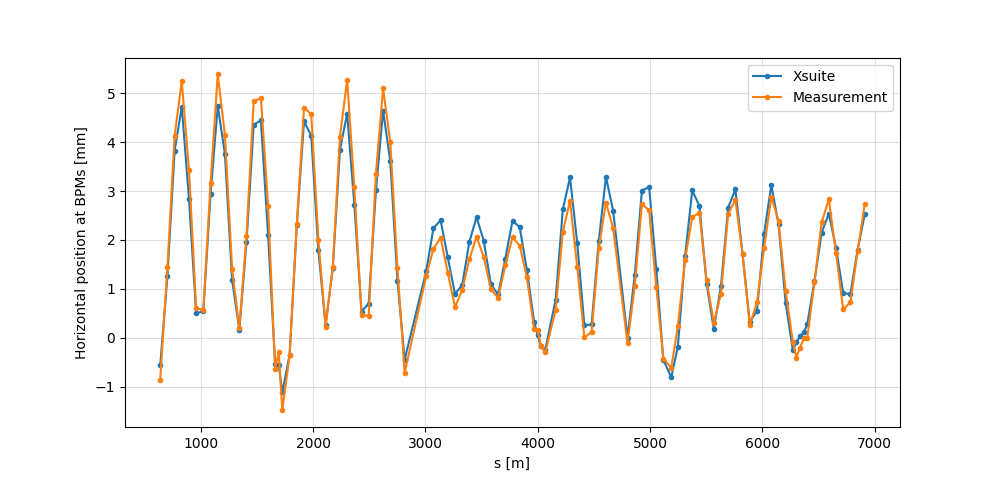

In [20]:
# Plot
plt.figure(figsize=(10, 4.8))
plt.plot(tw_turn_1_opt_at_bpms.s, tw_turn_1_opt_at_bpms.x * 1e3, '.-', label='Xsuite')
plt.plot(tw_turn_1_opt_at_bpms.s, bpm_meas['x_meas'] * 1e3, '.-', label='Measurement')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('Horizontal position at BPMs [mm]')
plt.grid(True, alpha=0.4)